# Codecademy Portfolio Project - Biodiversity in National Parks

## Project Goal:

Gain insights on endangered species found in the US national parks, and use that insight to improve conservation methods.

## Initial Key Questions:

- What is the distribution of conservation_status for animals?
- Are certain types of species more likely to be endangered?
- Are the differences between species and their conservation status significant?
- Which species were spotted the most at each park?


## 1. Import All Libraries

In [1]:
## Pandas and Numpy
import pandas as pd
import numpy as np
import math

## Data Visualisation Modules
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib.colors import BoundaryNorm, ListedColormap, LogNorm

## Warnings
import warnings
warnings.filterwarnings("ignore")

## Chi Contingency Test
from scipy.stats import chi2_contingency

## 2. Pre-Process the Data

### 2.1 Load & Inspect the Data

In [2]:
observations = pd.read_csv("observations.csv") ## Load the csv file and save as a dataframe
species = pd.read_csv("species_info.csv")

#### 2.1.1 Observations Data

In [3]:
observations.head()

,scientific_name,park_name,observations
0,Vicia benghalensis,Great Smoky Mountains National Park,68
1,Neovison vison,Great Smoky Mountains National Park,77
2,Prunus subcordata,Yosemite National Park,138
3,Abutilon theophrasti,Bryce National Park,84
4,Githopsis specularioides,Great Smoky Mountains National Park,85


In [4]:
observations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23296 entries, 0 to 23295
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   scientific_name  23296 non-null  object
 1   park_name        23296 non-null  object
 2   observations     23296 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 546.1+ KB


Analysis:
- For the "observations" data, there are only 3 columns: "scientific_name", "park_name", and "observations".
- There are 23296 non-null observations (rows) in the data.
- "scientific_name" and "park_name" columns are in string format, and "observations" column is in integer.

In [5]:
observations.scientific_name.unique()

array(['Vicia benghalensis', 'Neovison vison', 'Prunus subcordata', ...,
       'Ranunculus hebecarpus', 'Gulo gulo', 'Dichanthelium depauperatum'],
      dtype=object)

In [6]:
observations.scientific_name.nunique()

5541

Analysis:
- There are 5541 unique species, based on their unique scientific names.

In [7]:
observations.park_name.nunique()

4

In [8]:
observations.park_name.unique()

array(['Great Smoky Mountains National Park', 'Yosemite National Park',
       'Bryce National Park', 'Yellowstone National Park'], dtype=object)

Analysis:
- There are only 4 unique park names: "Great Smoky Mountains National Park", "Yosemite National Park", "Bryce National Park", and "Yellowstone National Park".
- If each species were recorded without duplicates for each park, then we should have 22164 records, but we have 23296 records, meaning that some species were recorded more than once at each park.

In [9]:
observations.isnull().sum()

scientific_name    0
park_name          0
observations       0
dtype: int64

Analysis:
- There are no null values for observations data.

#### 2.1.2 Species Info Data

In [10]:
species.head()

,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN
1,Mammal,Bos bison,"American Bison, Bison",NaN
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",NaN
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",NaN
4,Mammal,Cervus elaphus,Wapiti Or Elk,NaN


In [11]:
species.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5824 entries, 0 to 5823
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   category             5824 non-null   object
 1   scientific_name      5824 non-null   object
 2   common_names         5824 non-null   object
 3   conservation_status  191 non-null    object
dtypes: object(4)
memory usage: 182.1+ KB


In [12]:
species.shape

(5824, 4)

In [13]:
count = species.conservation_status.shape[0]
null_pct = (1-species.conservation_status.count()/count) * 100
round(null_pct, 2)

96.72

Analysis:
- There are 4 columns in species data: "category", "scientific_name", "common_names" and "conservation_staus".
- There are 5824 rows in total.
- The conservation status columns contain a significant number of null values (96.72%). It might be better to drop this column entirely, unless there is a good method to impute or interpolate the missing values.
- "Common names" is a string that includes multiple names separated by a comma or the word "or".


In [14]:
columns = species.columns

for column in columns:
    print(f"\nThe number of unique values in {column} columns: {species[column].nunique()}")
    if species[column].nunique() <= 10:
        print(f"The unique values are: {species[column].unique()}\n")



The number of unique values in category columns: 7
The unique values are: ['Mammal' 'Bird' 'Reptile' 'Amphibian' 'Fish' 'Vascular Plant'
 'Nonvascular Plant']


The number of unique values in scientific_name columns: 5541

The number of unique values in common_names columns: 5504

The number of unique values in conservation_status columns: 4
The unique values are: [nan 'Species of Concern' 'Endangered' 'Threatened' 'In Recovery']



Analysis:
- There are 7 unique categories: "Mammal", "Bird", "Reptile", "Amphibian", "Fish", "Vascular Plant", and "Nonvascular Plant".
- The number of unique scientific names in the species data matches the number in the observations data.
- However, we expected to see the number of unique species match the number of total rows in the species data. This means that some species have extra observations in the data (duplicate).
- The number of unique common names also don't match the scientific names, indicating that a common name may have multiple scientific names.
- The conservation status is divided into four groups: "Species of Concern", "Endangered", "Threatened", and "In Recovery". The remaining values are null. The null values likely indicate that the species in question is not in danger or threatened. We could replace the null value as simply "Safe" or similar term.

### 2.2 Data Cleaning

#### 2.2.1 Conservation Status

The term for non-endangered species is "least-concern species". We will therefore replace null values with "Least-concern"

In [15]:
species.conservation_status = species["conservation_status"].fillna('Least-concern')

In [16]:
species.conservation_status.unique()

array(['Least-concern', 'Species of Concern', 'Endangered', 'Threatened',
       'In Recovery'], dtype=object)

#### 2.2.2 Duplicates

In [17]:
duplicates = species.scientific_name[species.duplicated(subset=['scientific_name']) == True]

In [18]:
duplicates.shape

(283,)

There are 283 duplicates.

In [19]:
duplicates

3017                      Cervus elaphus
3019              Odocoileus virginianus
3020                         Canis lupus
3022                       Puma concolor
3025                    Lutra canadensis
                      ...               
5619    Panicum rigidulum var. rigidulum
5638                      Setaria pumila
5640                    Vulpia bromoides
5643                       Vulpia myuros
5750                     Rosa eglanteria
Name: scientific_name, Length: 283, dtype: object

In [20]:
species[species.scientific_name == "Cervus elaphus"]

,category,scientific_name,common_names,conservation_status
4,Mammal,Cervus elaphus,Wapiti Or Elk,Least-concern
3017,Mammal,Cervus elaphus,Rocky Mountain Elk,Least-concern


In [21]:
species[species.scientific_name == "Odocoileus virginianus"]

,category,scientific_name,common_names,conservation_status
5,Mammal,Odocoileus virginianus,White-Tailed Deer,Least-concern
3019,Mammal,Odocoileus virginianus,"White-Tailed Deer, White-Tailed Deer",Least-concern


In [22]:
for dup in duplicates[0:10]:
    print(species[["scientific_name", "common_names"]][species.scientific_name == dup])
    print(f"\n")

     scientific_name        common_names
4     Cervus elaphus       Wapiti Or Elk
3017  Cervus elaphus  Rocky Mountain Elk


             scientific_name                          common_names
5     Odocoileus virginianus                     White-Tailed Deer
3019  Odocoileus virginianus  White-Tailed Deer, White-Tailed Deer


     scientific_name     common_names
8        Canis lupus        Gray Wolf
3020     Canis lupus  Gray Wolf, Wolf
4448     Canis lupus  Gray Wolf, Wolf


     scientific_name                 common_names
16     Puma concolor      Panther (Mountain Lion)
3022   Puma concolor  Cougar, Mountain Lion, Puma
4451   Puma concolor                Mountain Lion


       scientific_name          common_names
20    Lutra canadensis  Northern River Otter
3025  Lutra canadensis           River Otter


     scientific_name         common_names
25     Mustela vison                 Mink
3028   Mustela vison  American Mink, Mink


     scientific_name                               

Analysis:
- After observing the duplicate data, it is confirmed that these are indeed duplicates. The common names column contains duplicate information that can be safely removed from the data without the risk of losing any information.

In [23]:
for dup in duplicates:
    inc_cs = []
    value = species[["conservation_status"]].loc[species.scientific_name == dup]
    status = list(value.conservation_status.values)
    if len(set(status)) > 1:
        print(dup)


Canis lupus
Oncorhynchus mykiss
Canis lupus


In [24]:
species[species.scientific_name == "Canis lupus"]

,category,scientific_name,common_names,conservation_status
8,Mammal,Canis lupus,Gray Wolf,Endangered
3020,Mammal,Canis lupus,"Gray Wolf, Wolf",In Recovery
4448,Mammal,Canis lupus,"Gray Wolf, Wolf",Endangered


According to US Fish & Wildlife Service: <br><br>
Gray wolves were originally listed under the Endangered Species Act as subspecies or as regional populations of subspecies in the contiguous United States and Mexico. In 1978, we reclassified the gray wolf as endangered at the species level (C. lupus) throughout the contiguous United States and Mexico, except for gray wolves in Minnesota which were classified as threatened. The Northern Rocky Mountains population was delisted due to recovery in 2011, except for Wyoming which was delisted in 2017. Remaining wolf populations in the contiguous United States were delisted due to recovery in 2021.

<br>
<br>
- We will repalce the status for gray wolf to "In Recovery".

In [25]:
species.conservation_status[species.scientific_name == "Canis lupus"] = species.conservation_status.replace({"Endangered": "In Recovery"})

In [26]:
species[species.scientific_name == "Canis lupus"]

,category,scientific_name,common_names,conservation_status
8,Mammal,Canis lupus,Gray Wolf,In Recovery
3020,Mammal,Canis lupus,"Gray Wolf, Wolf",In Recovery
4448,Mammal,Canis lupus,"Gray Wolf, Wolf",In Recovery


In [27]:
species[species.scientific_name == "Oncorhynchus mykiss"]

,category,scientific_name,common_names,conservation_status
560,Fish,Oncorhynchus mykiss,Rainbow Trout,Least-concern
3283,Fish,Oncorhynchus mykiss,Rainbow Trout,Threatened


Analysis:
- According to Wikipedia, _Some local populations of specific subspecies, or in the case of steelhead, distinct population segments, are listed as either threatened or endangered under the Endangered Species Act._
- We will replace the conservation status for this rainbow trout to "Threatened".

In [28]:
species.conservation_status[species.scientific_name == "Oncorhynchus mykiss"] = species.conservation_status.replace({"Least-concern": "Threatened"})

In [29]:
# dropping duplicate values and keeping only the first
species.drop_duplicates(subset="scientific_name",
                        keep="first", inplace=True)

In [30]:
species.shape

(5541, 4)

The number of species in the species data now matches the number of species in the observation data.

In [31]:
species.reset_index(inplace=True, drop=True)

#### 2.2.3 Keep Only One Common Name for Each Species

In [32]:
species.common_names

0                                Gapper's Red-Backed Vole
1                                   American Bison, Bison
2       Aurochs, Aurochs, Domestic Cattle (Feral), Dom...
3       Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)
4                                           Wapiti Or Elk
                              ...                        
5536                                  Parish's Nightshade
5537              Chaparral Nightshade, Purple Nightshade
5538          Thicket Creeper, Virginia Creeper, Woodbine
5539              California Grape, California Wild Grape
5540    Bullhead, Caltrop, Goathead, Mexican Sandbur, ...
Name: common_names, Length: 5541, dtype: object

Here, we will pick the first common name, and discard the rest. The delimiters are "," and "Or"

In [33]:
species.sort_values(by="common_names")

,category,scientific_name,common_names,conservation_status
2295,Vascular Plant,Poa saltuensis,"A Bluegrass, Bluegrass",Least-concern
2549,Vascular Plant,Rubus occidentalis,"A Bramble, Black Raspberry",Least-concern
2541,Vascular Plant,Rubus alumnus,"A Bramble, Blackberry",Least-concern
2542,Vascular Plant,Rubus argutus,"A Bramble, Highbush Blackberry",Least-concern
2554,Vascular Plant,Rubus trux,"A Bramble, Truculent Blackberry",Least-concern
...,...,...,...,...
3033,Mammal,Myotis yumanensis,"Yuma Myotis, Yuma Myotis",Species of Concern
5405,Vascular Plant,Delphinium patens ssp. patens,Zigzag Larkspur,Least-concern
1161,Vascular Plant,Tradescantia subaspera,Zigzag Spiderwort,Least-concern
2957,Nonvascular Plant,Zygodon viridissimus var. rupestris,Zygodon Moss,Least-concern


In [34]:
temp = species.copy()
temp = temp["common_names"].str.rsplit(",", 10, expand=True) 

In [35]:
temp = temp[0].str.rsplit(" Or ", 1, expand=True) 

In [36]:
species["common_names"] = temp[0]

In [37]:
species.sort_values(by=["common_names"])

,category,scientific_name,common_names,conservation_status
2295,Vascular Plant,Poa saltuensis,A Bluegrass,Least-concern
2541,Vascular Plant,Rubus alumnus,A Bramble,Least-concern
2542,Vascular Plant,Rubus argutus,A Bramble,Least-concern
2549,Vascular Plant,Rubus occidentalis,A Bramble,Least-concern
2554,Vascular Plant,Rubus trux,A Bramble,Least-concern
...,...,...,...,...
3033,Mammal,Myotis yumanensis,Yuma Myotis,Species of Concern
5405,Vascular Plant,Delphinium patens ssp. patens,Zigzag Larkspur,Least-concern
1161,Vascular Plant,Tradescantia subaspera,Zigzag Spiderwort,Least-concern
2957,Nonvascular Plant,Zygodon viridissimus var. rupestris,Zygodon Moss,Least-concern


#### 2.2.4 Remove "A" at the Beginning of a Common Name

In [38]:
temp = species.copy()

In [39]:
string = temp.common_names.iloc[2295]
string[1] == " "
x = string.lstrip("A ")
x

'Bluegrass'

In [40]:
for i in range(len(temp.common_names)):
    string = temp.common_names[i]
    if string[1] == " ":
        new_string = string.lstrip("A ")
        temp.common_names[i] = new_string
    else:
        pass

In [41]:
temp.sort_values(by=["common_names"])

,category,scientific_name,common_names,conservation_status
2908,Nonvascular Plant,Abietinella abietina,Abietinella Moss,Least-concern
3730,Vascular Plant,Astragalus australis var. glabriusculus,Aboriginal Milkvetch,Least-concern
5195,Vascular Plant,Carex abrupta,Abruptbeak Sedge,Least-concern
3360,Vascular Plant,Artemisia absinthium,Absinth Sagewort,Least-concern
316,Bird,Empidonax virescens,Acadian Flycatcher,Least-concern
...,...,...,...,...
3033,Mammal,Myotis yumanensis,Yuma Myotis,Species of Concern
5405,Vascular Plant,Delphinium patens ssp. patens,Zigzag Larkspur,Least-concern
1161,Vascular Plant,Tradescantia subaspera,Zigzag Spiderwort,Least-concern
2956,Nonvascular Plant,Zygodon viridissimus,Zygodon Moss,Least-concern


In [42]:
species.common_names = temp.common_names

In [43]:
species.common_names

0       Gapper's Red-Backed Vole
1                 American Bison
2                        Aurochs
3                 Domestic Sheep
4                         Wapiti
                  ...           
5536         Parish's Nightshade
5537        Chaparral Nightshade
5538             Thicket Creeper
5539            California Grape
5540                    Bullhead
Name: common_names, Length: 5541, dtype: object

#### 2.2.5 Combine Species and Observations Dataframe into a Single Dataframe.

In [44]:
df = observations.copy()

In [45]:
df = pd.merge(df, species, on="scientific_name")

In [46]:
df

,scientific_name,park_name,observations,category,common_names,conservation_status
0,Vicia benghalensis,Great Smoky Mountains National Park,68,Vascular Plant,Purple Vetch,Least-concern
1,Vicia benghalensis,Yosemite National Park,148,Vascular Plant,Purple Vetch,Least-concern
2,Vicia benghalensis,Yellowstone National Park,247,Vascular Plant,Purple Vetch,Least-concern
3,Vicia benghalensis,Bryce National Park,104,Vascular Plant,Purple Vetch,Least-concern
4,Neovison vison,Great Smoky Mountains National Park,77,Mammal,American Mink,Least-concern
...,...,...,...,...,...,...
23291,Gulo gulo,Yosemite National Park,157,Mammal,Wolverine,Least-concern
23292,Dichanthelium depauperatum,Great Smoky Mountains National Park,88,Vascular Plant,Green Panic-Grass,Least-concern
23293,Dichanthelium depauperatum,Bryce National Park,80,Vascular Plant,Green Panic-Grass,Least-concern
23294,Dichanthelium depauperatum,Yellowstone National Park,255,Vascular Plant,Green Panic-Grass,Least-concern


In [47]:
species[species.scientific_name == "Bos bison"]

,category,scientific_name,common_names,conservation_status
1,Mammal,Bos bison,American Bison,Least-concern


In [48]:
observations[observations.scientific_name == "Bos bison"]

,scientific_name,park_name,observations
2472,Bos bison,Yosemite National Park,128
7578,Bos bison,Yellowstone National Park,269
13800,Bos bison,Bryce National Park,68
16868,Bos bison,Great Smoky Mountains National Park,77


In [49]:
df[df.scientific_name == "Bos bison"]

,scientific_name,park_name,observations,category,common_names,conservation_status
8940,Bos bison,Yosemite National Park,128,Mammal,American Bison,Least-concern
8941,Bos bison,Yellowstone National Park,269,Mammal,American Bison,Least-concern
8942,Bos bison,Bryce National Park,68,Mammal,American Bison,Least-concern
8943,Bos bison,Great Smoky Mountains National Park,77,Mammal,American Bison,Least-concern


## 3. Exploratory Data Analysis

### 3.1 Distribution of Endangered and Least-Concern Groups For Each Category

In [50]:
categories = ["Mammal", "Bird", "Amphibian", "Reptile", "Fish", "Vascular Plant", "Nonvascular Plant"]

In [51]:
categories

['Mammal',
 'Bird',
 'Amphibian',
 'Reptile',
 'Fish',
 'Vascular Plant',
 'Nonvascular Plant']

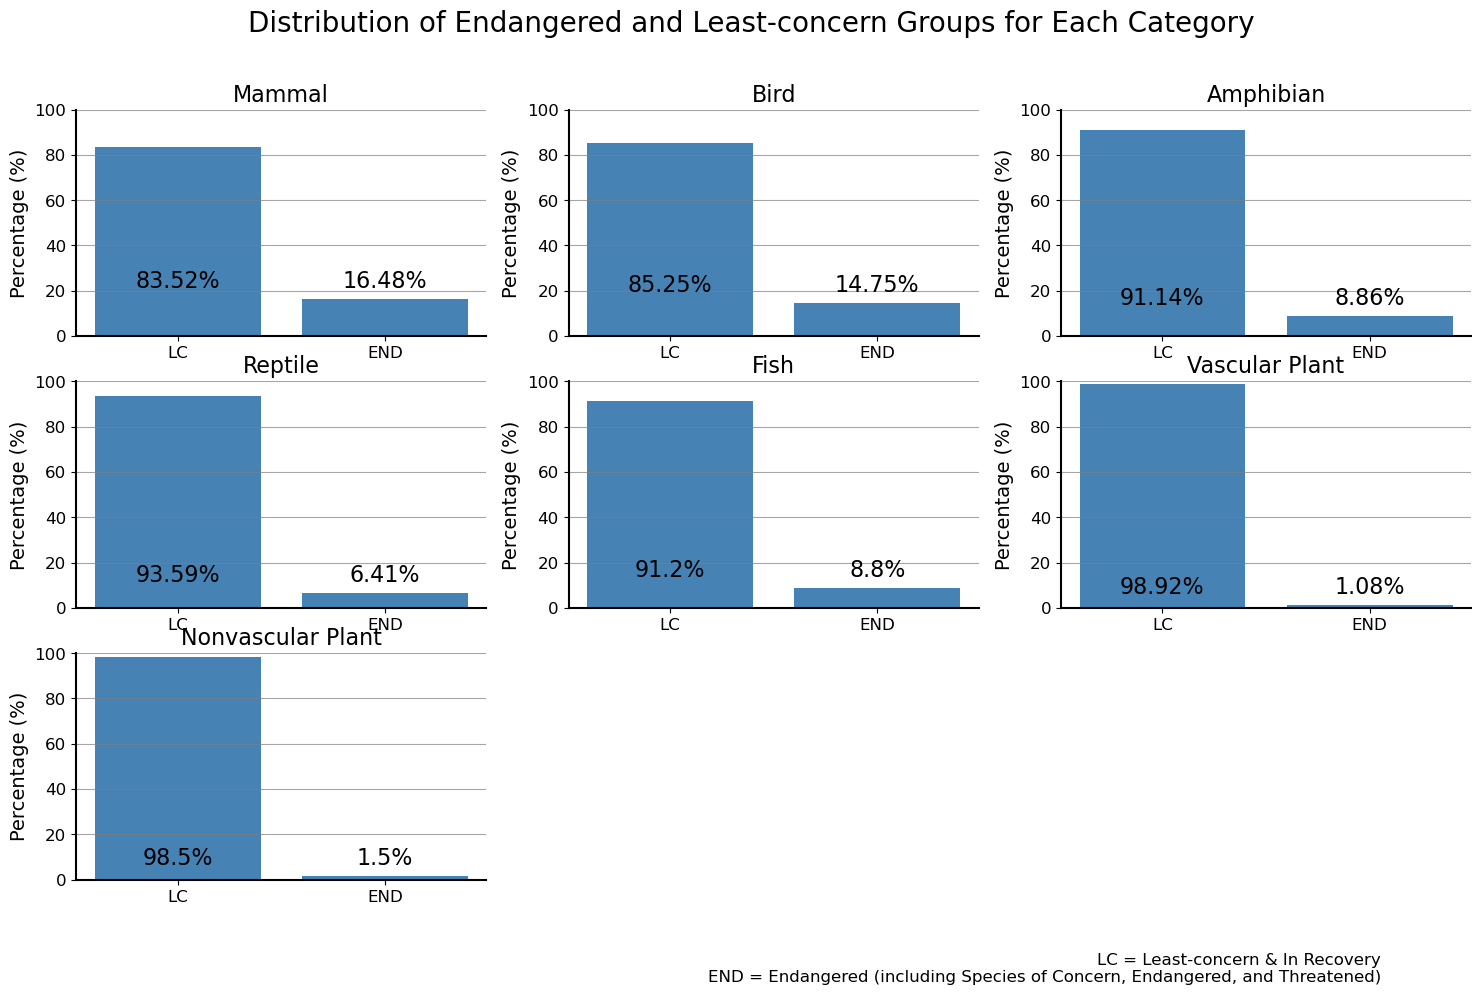

In [52]:
## Plot yearly precentage change in GDP for individual countries
nrow = 3
ncol = 3
fig, axes = plt.subplots(nrow, ncol, figsize=(18, 10))
plt.rcParams['font.size'] = 12
fig.suptitle(f"Distribution of Endangered and Least-concern Groups for Each Category",
              fontsize = 20)

for index, cat in enumerate(categories):
    ## Create a temporary dataframe and do necessary calculations
    temp_df = species[species.category == cat]
    
    total_count = temp_df.shape[0]
    least_count = temp_df.category[temp_df.conservation_status == "Least-concern"].count()
    least_count = least_count + temp_df.category[temp_df.conservation_status == "In Recovery"].count()
    end_count = total_count - least_count
    
    least_pct = least_count / total_count * 100
    end_pct = end_count / total_count * 100

    ## Plot the graph
    ax = plt.subplot(nrow, ncol, index+1)
    
    ax.bar(x = ["LC", "END"],
           height = [least_pct, end_pct],
           color = "steelblue")
    
    ax.set_ylim(0, 100)

    ax.grid(alpha = 0.7, color='gray', axis="y")
    ax.set_ylabel(f"Percentage (%)", fontsize = 14)
    plt.title(f"{cat.title()}", fontsize = 16)
        
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    
    sns.despine(ax=ax, offset=0)
    
    plt.annotate(f"{round(least_pct, 2)}%", 
                 xy = [0, end_pct+5], 
                 horizontalalignment = 'center',
                 color = 'black',
                 fontsize = 16)
    
    plt.annotate(f"{round(end_pct, 2)}%", 
                 xy = [1, end_pct+5], 
                 horizontalalignment = 'center',
                 color = 'black',
                 fontsize = 16)

axs1  = plt.subplot(nrow, ncol, 8)
axs2  = plt.subplot(nrow, ncol, 9)
fig.delaxes(axs1)
fig.delaxes(axs2)

txt=f"LC = Least-concern & In Recovery\nEND = Endangered (including Species of Concern, Endangered, and Threatened)"
plt.figtext(0.85, 0.01, txt, wrap=True, horizontalalignment='right', fontsize=12) 

plt.show()

Analysis:
- Here, we consider "endangered" to include "species of concern", "endangered" and "threatened".
- Of all the categories, __mammals and birds are the top two categories that are most likely to be endangered__ based on their ratio of endangered to least-concern (around 16% of mammals and 15% of birds are endangered).
- Both vascular and nonvascular plants are least likely to be endangered.

### 3.2 Distribution of Conservation Status for Animals

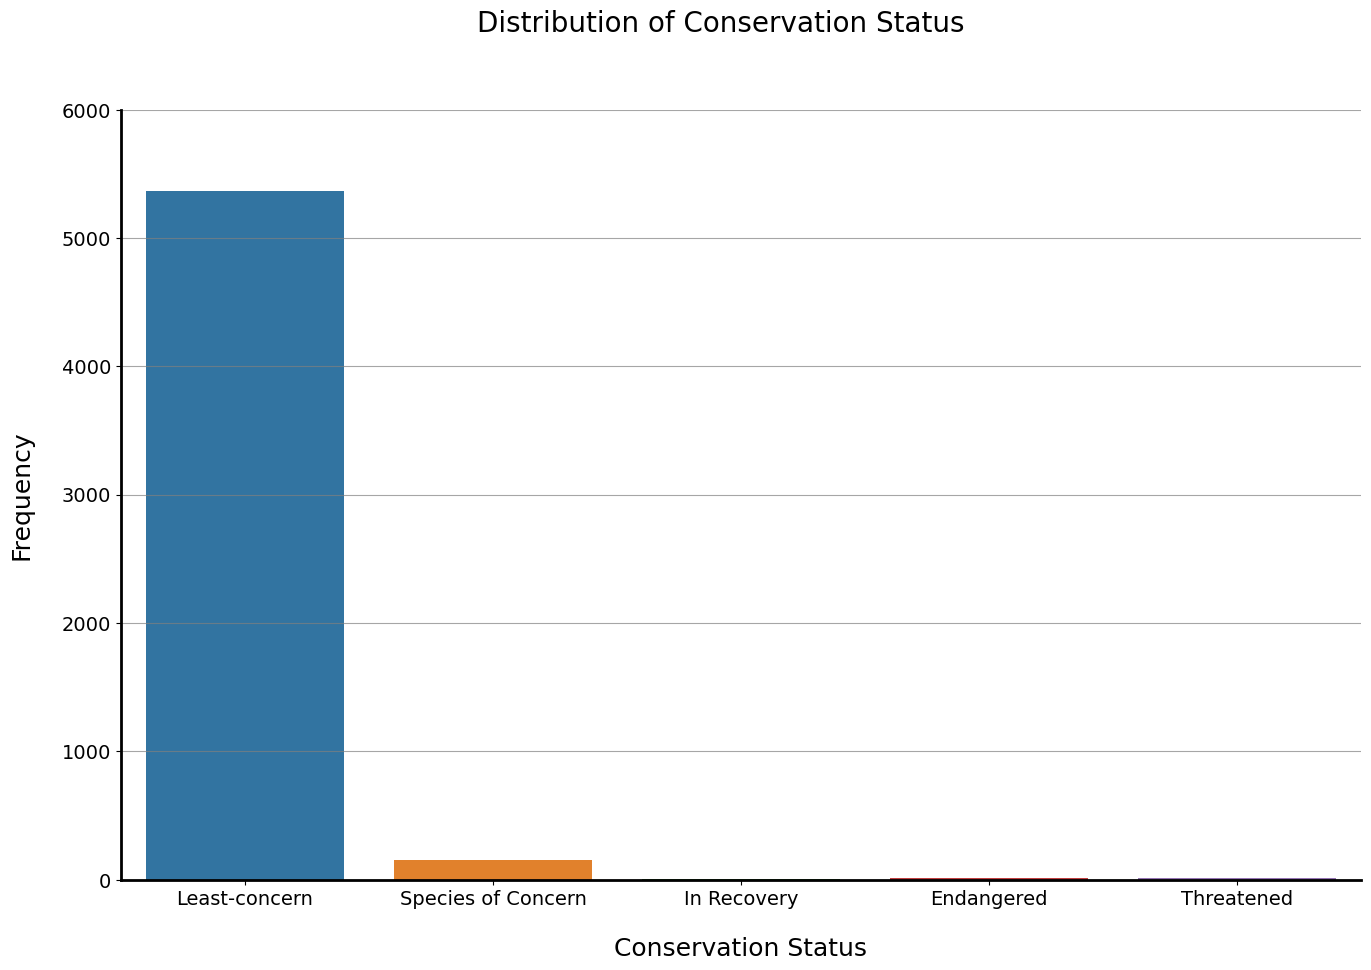

In [53]:
## Plot Conservation Status
nrow = 1
ncol = 1
fig, axes = plt.subplots(nrow, ncol, figsize=(16, 10))
plt.rcParams['font.size'] = 14
fig.suptitle(f"Distribution of Conservation Status",
              fontsize = 20)

ax = plt.subplot(nrow, ncol, 1)
sns.countplot(x = "conservation_status",
              data = species)

plt.xlabel("Conservation Status", fontsize=18, labelpad=20)
plt.ylabel("Frequency", fontsize=18, labelpad=20)

plt.yticks(fontsize=16)
plt.xticks(fontsize = 16)

ax.grid(alpha = 0.7, color='gray', axis="y")
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)

ax.set_ylim(0, 6000)

sns.despine(ax=ax, offset=0)

plt.show()

Analysis:
- Least-concern species are around 97% of the total number of species.
- We should remove the least-concern species from this analysis to see the distribution of species in danger.

In [54]:
endangered = species.copy()
endangered = endangered[endangered.conservation_status != "Least-concern"]
endangered

,category,scientific_name,common_names,conservation_status
7,Mammal,Canis latrans,Coyote,Species of Concern
8,Mammal,Canis lupus,Gray Wolf,In Recovery
9,Mammal,Canis rufus,Red Wolf,Endangered
29,Mammal,Eptesicus fuscus,Big Brown Bat,Species of Concern
30,Mammal,Lasionycteris noctivagans,Silver-Haired Bat,Species of Concern
...,...,...,...,...
5049,Vascular Plant,Callitriche marginata,Winged Water-Starwort,Species of Concern
5140,Vascular Plant,Camissonia sierrae ssp. alticola,Mono Hot Springs Evening Primrose,Species of Concern
5166,Vascular Plant,Epilobium oreganum,Grants Pass Willowherb,Species of Concern
5175,Vascular Plant,Botrychium ascendens,Trianglelobe Moonwort,Species of Concern


In [55]:
groups = ['Species of Concern', 'Endangered', 'Threatened', 'In Recovery']
total_count = endangered.shape[0]
counts = [endangered.conservation_status[endangered.conservation_status == group].count() for group in groups]
pct = [endangered.conservation_status[endangered.conservation_status == group].count()/total_count * 100 for group in groups]

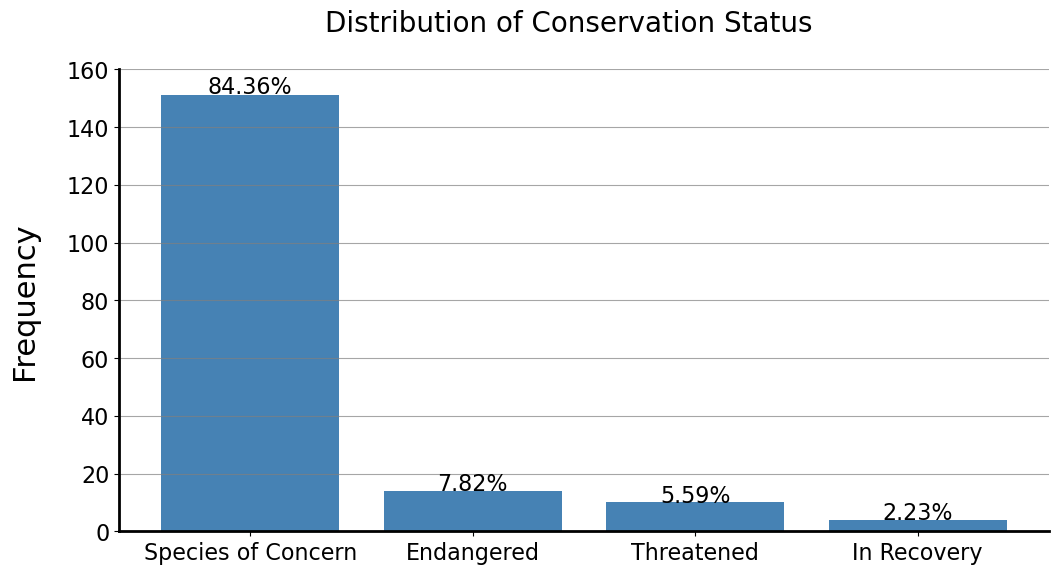

In [56]:
## Plot Conservation Status
nrow = 1
ncol = 1
fig, ax = plt.subplots(nrow, ncol, figsize=(12, 6))
plt.rcParams['font.size'] = 16
fig.suptitle(f"Distribution of Conservation Status",
              fontsize = 20)

ax = plt.subplot(nrow, ncol, 1)
ax.bar(x = groups,
       height = counts,
       color="steelblue")

# ax.set_xlabel("Conservation Status", fontsize=20, labelpad=20)
ax.set_ylabel("Frequency", fontsize=22, labelpad=20)

plt.yticks(fontsize=16)
plt.xticks(fontsize = 16)

ax.grid(alpha = 0.7, color='gray', axis="y")
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)

ax.set_ylim(0, 160)

sns.despine(ax=ax, offset=0)

for i in range(len(pct)):
    plt.annotate(f"{round(pct[i], 2)}%", 
                 xy = [i, pct[i]*180/100], 
                 horizontalalignment = 'center',
                 color = 'black',
                 fontsize = 16)


plt.show()

Analysis:
- Of those species that are endangered, around 85% are classed as "Species of Concern", 8% are classed as "endangered", 5% are classed as "Threatened" and only 2% are classed as "In Recovery".
- Let us now take a look at distribution of catergory for each conservation group.

In [57]:
cat_pct = {}
categories = endangered.category.unique()

for group in groups:
    group_count = endangered.conservation_status[endangered.conservation_status == group].count()
    cat_pct[group] = {}
    
    for cat in categories:
        cat_count = endangered.category[(endangered.conservation_status == group) &
                                        (endangered.category == cat)].count()
        cat_pct[group][cat] = round(cat_count/group_count * 100, 2)

In [58]:
cat_pct = pd.DataFrame(cat_pct)

In [59]:
cat_pct = cat_pct.T

In [60]:
cat_pct = cat_pct.reset_index()

In [61]:
categories

array(['Mammal', 'Bird', 'Reptile', 'Amphibian', 'Fish', 'Vascular Plant',
       'Nonvascular Plant'], dtype=object)

In [62]:
cat_pct

,index,Mammal,Bird,Reptile,Amphibian,Fish,Vascular Plant,Nonvascular Plant
0,Species of Concern,14.57,45.03,3.31,2.65,2.65,28.48,3.31
1,Endangered,35.71,28.57,0.00,7.14,21.43,7.14,0.00
2,Threatened,20.00,0.00,0.00,20.00,40.00,20.00,0.00
3,In Recovery,25.00,75.00,0.00,0.00,0.00,0.00,0.00


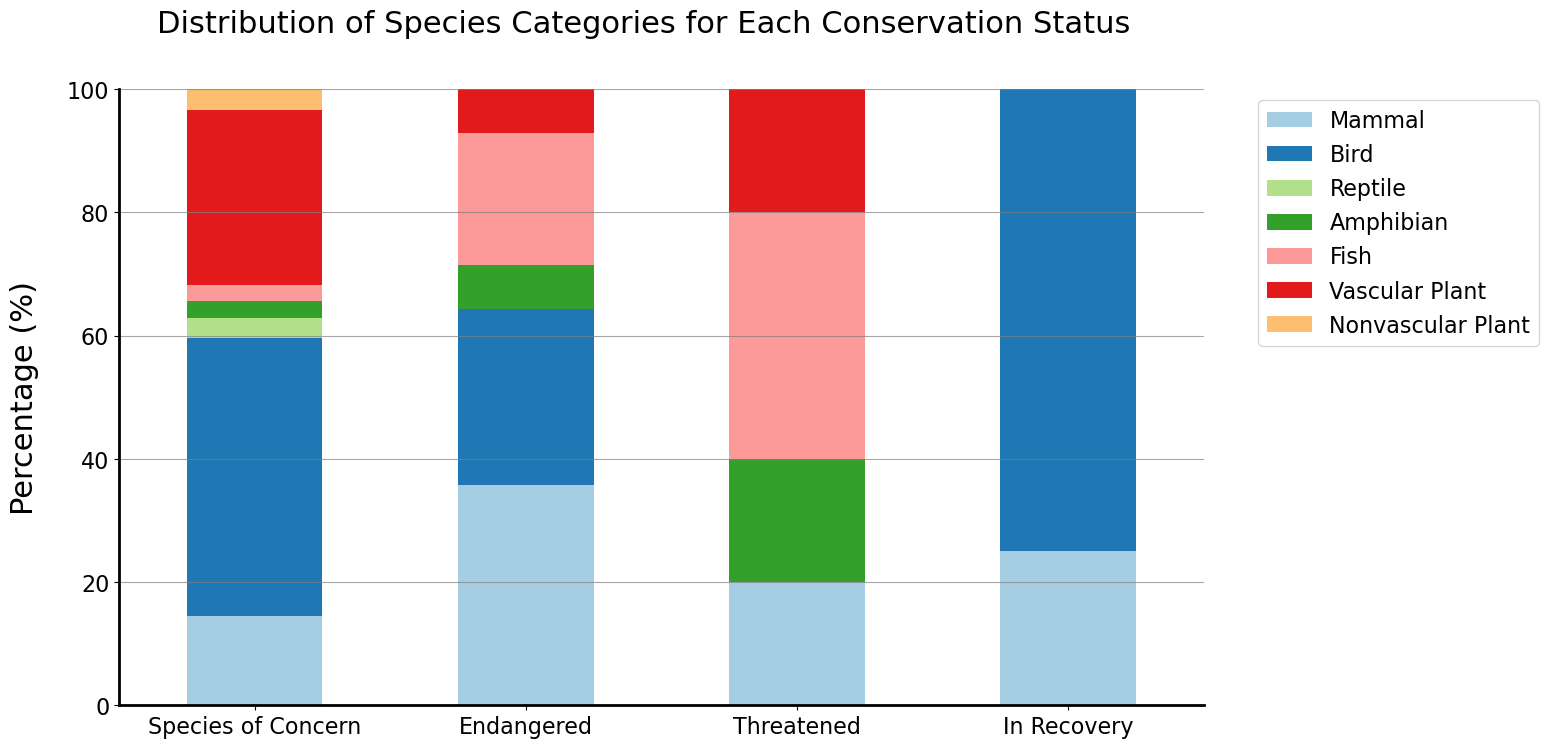

In [63]:
## plot data in stack manner of bar type
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111)
fig.suptitle(f"Distribution of Species Categories for Each Conservation Status",
              fontsize = 22)
sns.set_palette("Paired")
ax = cat_pct.plot.bar(x="index", stacked=True,  ax=ax)

ax.set_ylabel("Percentage (%)", fontsize=22, labelpad=20)
ax.set(xlabel=None)
plt.yticks(fontsize=16)
plt.xticks(fontsize = 20)

ax.grid(alpha = 0.7, color='gray', axis="y")
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)

ax.set_ylim(0, 100)

sns.despine(ax=ax, offset=0)

plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

plt.show()

Analysis:
- As we expected, the majority of species of concern and endangered speces are birds or mammals (~60%).
- Of those species that are threatened, the majority are fish or amphibian (60%). There are few mammals and vascular plants that are also threatened, but no birds.
- Unlike vascular plants, no nonvascular plants are endangered or threatened.
- Only birds and mammals are in recovery.

In [64]:
## Closer look at endangered and threatened species

In [65]:
endangered[["common_names", "category"]][(endangered.conservation_status == "Endangered")|(endangered.conservation_status == "Threatened")].sort_values(by="category")

,common_names,category
4385,California Red-Legged Frog,Amphibian
4382,Yosemite Toad,Amphibian
4386,Sierra Nevada Yellow-Legged Frog,Amphibian
4306,California Condor,Bird
173,Whooping Crane,Bird
276,Bachman's Warbler,Bird
343,Red-Cockaded Woodpecker,Bird
570,Smoky Madtom,Fish
3238,June Sucker,Fish
571,Yellowfin Madtom,Fish


Analysis:
- From external sources, we find that the primary reason why these particular species are endangered is the loss of habitat. Most of these species' habitats are found in swamps or caves, which are declining in number.
- It will be interesting to find external dataset that details the habitat of these species and other information for further analysis.

### 3.3 Category Most At Risk

In [66]:
## Which category is most at risk?
endangered = endangered[endangered.conservation_status != "In Recovery"]
end_group = endangered.groupby("category").count()
end_group

,scientific_name,common_names,conservation_status
category,,,
Amphibian,7,7,7
Bird,72,72,72
Fish,11,11,11
Mammal,29,29,29
Nonvascular Plant,5,5,5
Reptile,5,5,5
Vascular Plant,46,46,46


In [67]:
end_group_pct = []
total_count = end_group.conservation_status.sum()

end_group_pct.append(round(end_group.conservation_status/total_count * 100, 2))

In [68]:
end_group_pct = pd.DataFrame(end_group_pct).T

In [69]:
end_group_pct = end_group_pct.sort_values(by=["conservation_status"], ascending=False)
end_group_pct

,conservation_status
category,
Bird,41.14
Vascular Plant,26.29
Mammal,16.57
Fish,6.29
Amphibian,4.00
Nonvascular Plant,2.86
Reptile,2.86


In [70]:
list(end_group_pct.index)

['Bird',
 'Vascular Plant',
 'Mammal',
 'Fish',
 'Amphibian',
 'Nonvascular Plant',
 'Reptile']

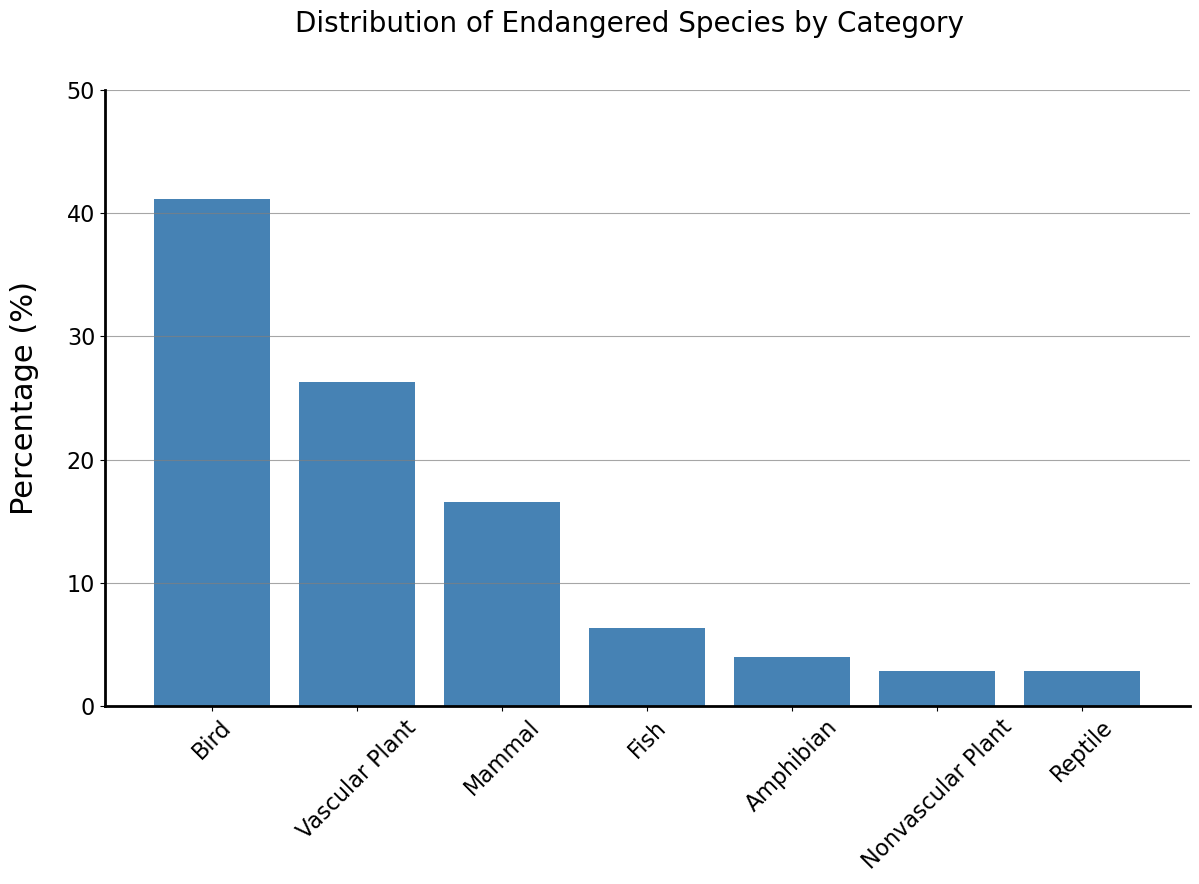

In [71]:
categories = list(end_group_pct.index)
## Plot Conservation Status
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111)
fig.suptitle(f"Distribution of Endangered Species by Category",
              fontsize = 20)

ax.bar(end_group_pct.index, 
       end_group_pct.conservation_status,
       color="steelblue")

ax.set_xticklabels(categories, rotation = 45)
ax.set_ylabel("Percentage (%)", fontsize=22, labelpad=20)

ax.grid(alpha = 0.7, color='gray', axis="y")
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)

ax.set_ylim(0, 50)

sns.despine(ax=ax)

plt.show()

Analysis:
- Majority of endangered species are birds at 40%, followed by vascular plants (25%) and mammals (16%).
- Conservation strategy should be geared towards protecting these species for more efficient use of resources.

### 3.4 Frequency of Rarest Observation

In [72]:
## Which species that are endangered are most rarely sighted?

In [73]:
df.head()

,scientific_name,park_name,observations,category,common_names,conservation_status
0,Vicia benghalensis,Great Smoky Mountains National Park,68,Vascular Plant,Purple Vetch,Least-concern
1,Vicia benghalensis,Yosemite National Park,148,Vascular Plant,Purple Vetch,Least-concern
2,Vicia benghalensis,Yellowstone National Park,247,Vascular Plant,Purple Vetch,Least-concern
3,Vicia benghalensis,Bryce National Park,104,Vascular Plant,Purple Vetch,Least-concern
4,Neovison vison,Great Smoky Mountains National Park,77,Mammal,American Mink,Least-concern


In [74]:
endangered = df.copy()
endangered = endangered[endangered.conservation_status != "Least-concern"]
end_group_species = endangered.groupby(endangered.common_names).sum()

In [75]:
min_index = np.argmin(end_group_species)
end_group_species.iloc[min_index]

observations    131
Name: Whooping Crane, dtype: int64

In [76]:
end_group_species.mean()

observations    503.396648
dtype: float64

In [77]:
all_group = df.groupby(df.common_names).sum()
all_group

,observations
common_names,
Abietinella Moss,592
Aboriginal Milkvetch,564
Abruptbeak Sedge,606
Absinth Sagewort,535
Acadian Flycatcher,549
...,...
Yuba Pass Willowherb,524
Yuma Myotis,538
Zigzag Larkspur,645


Analysis:
- Grus Americana, also known as Whooping Crane is the rarest species spotted. It has been only spotted 131 times compared to the average frequency of 503 for all endangered species.

In [78]:
lc_group = df[df.conservation_status == "Least-concern"]
lc_group = lc_group.groupby(df.common_names).sum()
lc_group

,observations
common_names,
Abietinella Moss,592
Aboriginal Milkvetch,564
Abruptbeak Sedge,606
Absinth Sagewort,535
Acadian Flycatcher,549
...,...
Yosemite Tarweed,594
Yuba Pass Willowherb,524
Zigzag Larkspur,645


In [79]:
lc_group.mean()

observations    653.818127
dtype: float64

In [80]:
frequencies = {}

for cat in categories:
    temp_df = endangered[endangered.category == cat]
    temp_df_group = temp_df.groupby(temp_df.common_names).sum()
    min_index = np.argmin(temp_df_group)
    name = temp_df_group.iloc[min_index].name
    freq = temp_df_group.iloc[min_index].values[0]
    avg = round(temp_df_group.mean().values[0],2)
    avg_all = round(all_group.mean().values[0],2)
    
    print(name, freq)
    
    frequencies[cat] = {"Name": name, 
                        "Frequency": freq, 
                        "Avg_End": avg,
                        "Avg_All": avg_all}

frequencies = pd.DataFrame(frequencies).T

Whooping Crane 131
Mountain Avens 162
Red Wolf 137
Smoky Madtom 143
Sierra Nevada Yellow-Legged Frog 144
Carolina Plagiomnium Moss 505
Northern Pine Snake 470


In [81]:
frequencies

,Name,Frequency,Avg_End,Avg_All
Bird,Whooping Crane,131,514.77,649.69
Vascular Plant,Mountain Avens,162,496.72,649.69
Mammal,Red Wolf,137,548.3,649.69
Fish,Smoky Madtom,143,382.64,649.69
Amphibian,Sierra Nevada Yellow-Legged Frog,144,393.14,649.69
Nonvascular Plant,Carolina Plagiomnium Moss,505,541.0,649.69
Reptile,Northern Pine Snake,470,507.2,649.69


Analysis:
- The average number of sightings for all species is 650, compared to 503 times for endangered species.   

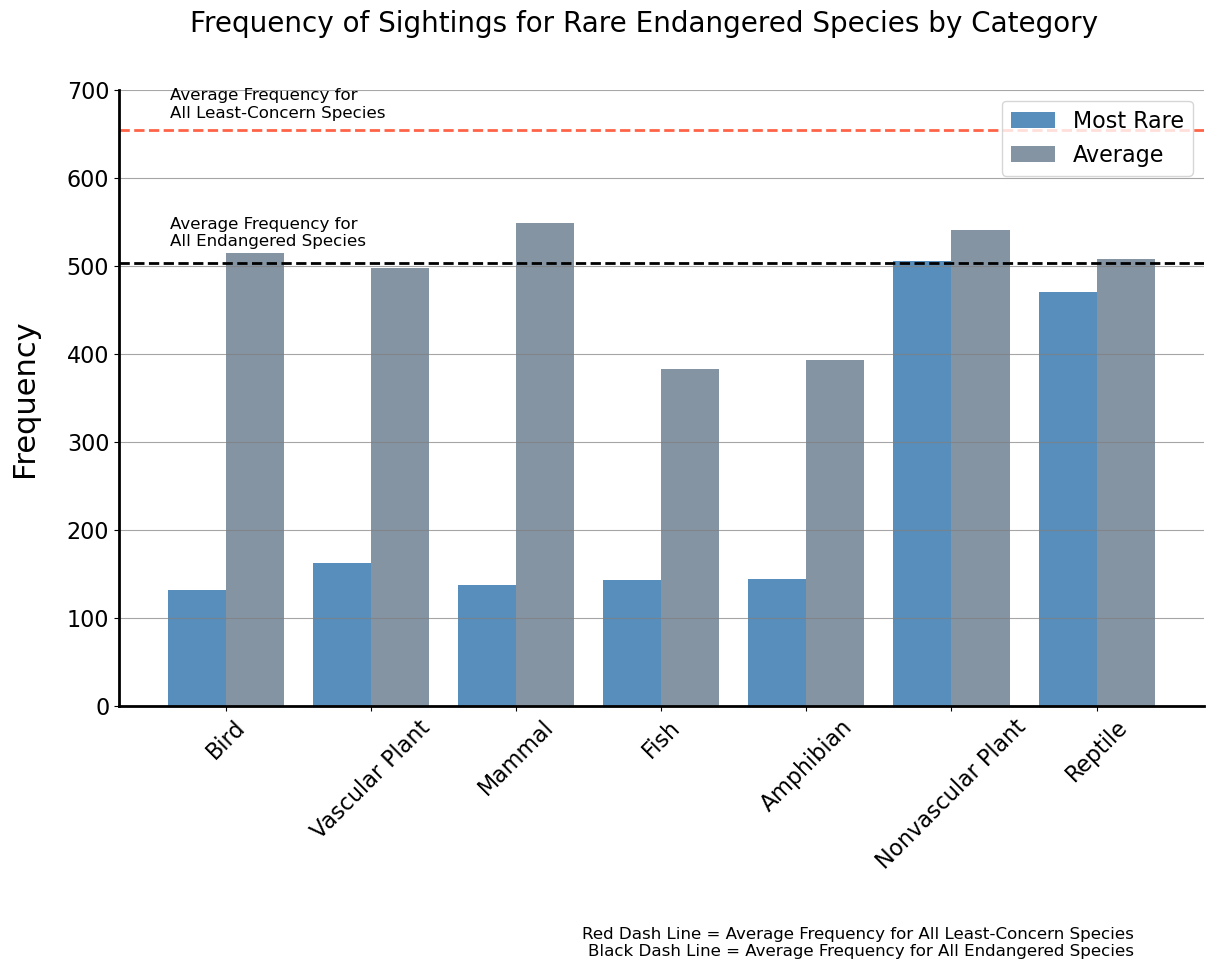

In [82]:
end_avg = end_group_species.mean().values[0]
lc_avg = lc_group.mean().values[0]

## Plot Frequency of Sightings
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111)
fig.suptitle(f"Frequency of Sightings for Rare Endangered Species by Category",
              fontsize = 20)

ax.bar(frequencies.index, 
       frequencies.Frequency,
       align='edge', 
       width=-0.4,
       color="steelblue",
       label="Most Rare",
       alpha=0.9)

ax.bar(frequencies.index, 
       frequencies.Avg_End,
       align='edge', 
       width=0.4,
       color="lightslategrey",
       label="Average",
       alpha=0.9)

ax.set_xticklabels(categories, rotation = 45)
ax.set_ylabel("Frequency", fontsize=22, labelpad=20)

ax.grid(alpha = 0.7, color='gray', axis="y")
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)

ax.set_ylim(0, 700)

sns.despine(ax=ax)

ax.axhline(y= end_avg, color = 'black', lw = 2, ls = "--")
ax.axhline(y= lc_avg, color = 'tomato', lw = 2, ls = "--")

ax.annotate("Average Frequency for \nAll Least-Concern Species", 
            (-0.5, all_group.mean()),
            fontsize=12,
            xytext=(12, 12), 
            textcoords='offset points')

ax.annotate(f"Average Frequency for \nAll Endangered Species", 
            (-0.5, end_group_species.mean()), 
            fontsize=12,
            xytext=(12, 12), 
            textcoords='offset points')

txt=f"Red Dash Line = Average Frequency for All Least-Concern Species\nBlack Dash Line = Average Frequency for All Endangered Species"
plt.figtext(0.85, -0.2, txt, wrap=True, horizontalalignment='right', fontsize=12) 

plt.legend()

plt.show()

Analysis:
- On average, least-concern species are sighted by roughly 150 times more than endangered species (650 vs 500).
- Fish and Amphibian Endangered Species are on average, the rarest categories of endangered species spotted overall.
- The most rarely spotted bird and mammal are Whooping Crane and Red Wolf, respectively. These species are around 5 times less likely to be spotted than other endangered species in their respective category.

### 3.5 Most Frequent Sightings by Each Park

In [83]:
## Which species were spotted the most at each park?

In [84]:
parks = list(df.park_name.unique())
frequencies = {}

for park in parks:
    temp_df = df[df.park_name == park]
    temp_df_group = temp_df.groupby(temp_df.common_names).sum()
    max_index = np.argmax(temp_df_group)
    name = temp_df_group.iloc[max_index].name
    freq = temp_df_group.iloc[max_index].values[0]
    avg = round(temp_df_group.mean().values[0],2)
    avg_all = round(all_group.mean().values[0],2)
    
    print(name, freq)
    
    frequencies[cat] = {"Name": name, 
                        "Frequency": freq, 
                        "Avg_End": avg,
                        "Avg_All": avg_all}

frequencies = pd.DataFrame(frequencies).T

Sedge 1390
Sedge 2797
Sedge 4436
Sedge 1770


Analysis:
- The most frequently spotted species in all four national parks is sedge, which is a common grass-like plant. This isn't very interesting so we'll look at the data excluding all plant types (plant types are more likely to be spotted than other categories).

In [85]:
df_no_plants = df[(df.category != "Vascular Plant") &  (df.category != "Nonvascular Plant")]
df_no_plants.category.unique()

array(['Mammal', 'Bird', 'Amphibian', 'Reptile', 'Fish'], dtype=object)

In [86]:
avg_all_no_plants = round(np.mean(df_no_plants.groupby(df_no_plants.common_names).sum()), 2)
avg_all_no_plants = avg_all_no_plants.values[0]
avg_all_no_plants

635.04

In [87]:
frequencies = {}
avg_all = np.mean(df_no_plants.groupby(df_no_plants.common_names).sum())

for park in parks:
    temp_df = df_no_plants[df_no_plants.park_name == park]
    temp_df_group = temp_df.groupby(temp_df.common_names).sum()
    max_index = np.argmax(temp_df_group)
    name = temp_df_group.iloc[max_index].name
    freq = temp_df_group.iloc[max_index].values[0]
    cat = species.category[species.common_names == name].values[0]
    avg = round(temp_df_group.mean().values[0],2)
    avg_all = round(all_group.mean().values[0],2)
    
    print(park, ": ", name, ", ", cat,  ", ", freq)
    
    frequencies[park] = {"Name": name, 
                        "Category": cat,
                        "Frequency": freq, 
                        "Avg_Park": avg,
                        "Avg_All": avg_all_no_plants}

frequencies = pd.DataFrame(frequencies).T

Great Smoky Mountains National Park :  Uinta Chipmunk ,  Mammal ,  261
Yosemite National Park :  American Beaver ,  Mammal ,  501
Yellowstone National Park :  Eurasian Collared-Dove ,  Bird ,  771
Bryce National Park :  Rock Dove ,  Bird ,  339


In [88]:
frequencies

,Name,Category,Frequency,Avg_Park,Avg_All
Great Smoky Mountains National Park,Uinta Chipmunk,Mammal,261,81.86,635.04
Yosemite National Park,American Beaver,Mammal,501,165.28,635.04
Yellowstone National Park,Eurasian Collared-Dove,Bird,771,276.35,635.04
Bryce National Park,Rock Dove,Bird,339,111.55,635.04


In [89]:
parks = [f'Great Smoky Mountains\nNational Park',
         f'Yosemite\nNational Park',
         f'Yellowstone\nNational Park',
         f'Bryce National Park']

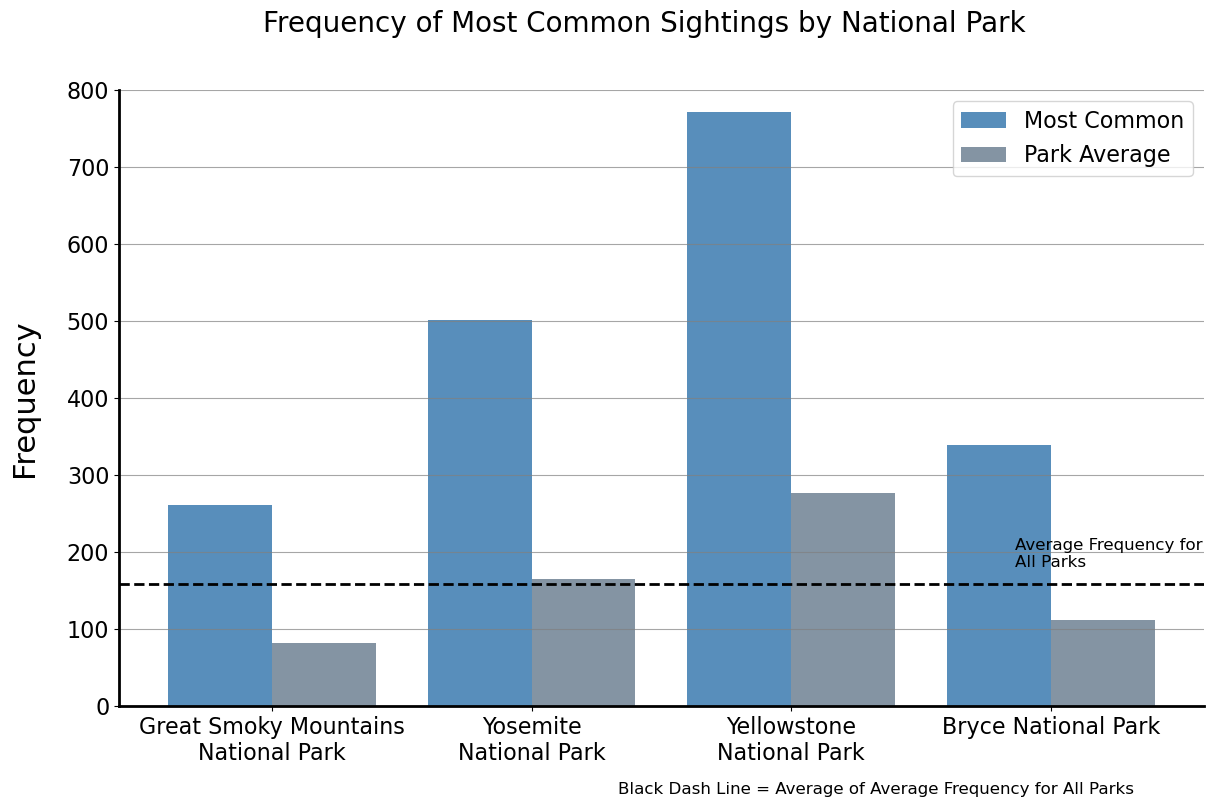

In [90]:
park_avg = frequencies.Avg_Park.mean()

## Plot Frequency of Sightings
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111)
fig.suptitle(f"Frequency of Most Common Sightings by National Park",
              fontsize = 20)

ax.bar(parks, 
       frequencies.Frequency,
       align='edge', 
       width=-0.4,
       color="steelblue",
       label="Most Common",
       alpha=0.9)

ax.bar(parks, 
       frequencies.Avg_Park,
       align='edge', 
       width=0.4,
       color="lightslategrey",
       label="Park Average",
       alpha=0.9)

ax.set_xticklabels(parks, rotation = 0)
ax.set_ylabel("Frequency", fontsize=22, labelpad=20)

ax.grid(alpha = 0.7, color='gray', axis="y")
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)

ax.set_ylim(0, 800)

sns.despine(ax=ax)

ax.axhline(y= park_avg, color = 'black', lw = 2, ls = "--")

ax.annotate("Average Frequency for \nAll Parks", 
            (2.8, park_avg),
            fontsize=12,
            xytext=(12, 12), 
            textcoords='offset points')


txt=f"Black Dash Line = Average of Average Frequency for All Parks"
plt.figtext(0.85, 0, txt, wrap=True, horizontalalignment='right', fontsize=12) 

plt.legend()

plt.show()

Analysis:
- Yellowstone has the highest average number of sightings per species followed by Yosemite. Coincidentally, these two parks are the largest parks of the four in the data.
- The most frequently sigted species is called Eurasian-collared dove at the Yellowstone National Park, which is sighted by roughly 2.5 times more than the average number of sightings at the park.
- Interestingly, Bryce National Park has a higher average number of sightings per species than Great Smoky Mountains National Park, although the size of Bryce National Park is smaller than Great Smoky Mountains National Park. This could be due to the difference in their habitat type. In other words, Bryce National Park's habitat provides more biodiversity especially for least-concern species that are commonly sighted than Great Smoky Mountains.

### 3.6 Hypothesis Testing - Difference Between Categoreis and Their Conservation Status

In [91]:
## Are the differences between categories and their conservation status significant?

We will perform Chi-squared tests (using chi2-contingency function) to test whether there are any significant differences between categories and their conservation status.
<br><br>
Here are the hypotheses:
- Null Hypothesis: There are no significant differences between the categories.
- Alternative: There are significant differences between the categories. 

In [92]:
temp_df = species.copy()
temp_df

,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,Least-concern
1,Mammal,Bos bison,American Bison,Least-concern
2,Mammal,Bos taurus,Aurochs,Least-concern
3,Mammal,Ovis aries,Domestic Sheep,Least-concern
4,Mammal,Cervus elaphus,Wapiti,Least-concern
...,...,...,...,...
5536,Vascular Plant,Solanum parishii,Parish's Nightshade,Least-concern
5537,Vascular Plant,Solanum xanti,Chaparral Nightshade,Least-concern
5538,Vascular Plant,Parthenocissus vitacea,Thicket Creeper,Least-concern
5539,Vascular Plant,Vitis californica,California Grape,Least-concern


In [93]:
count_dict = {}
categories = list(temp_df.category)

for cat in categories:
    temp = temp_df.conservation_status[temp_df.category == cat]
    total_count = len(temp)
    temp = list(temp.values)
    lc = temp.count("Least-concern")
    end_count = total_count - lc
    count_dict[cat] = {"total": total_count,
                       "lc": lc,
                       "endangered": end_count}

In [94]:
count_df = pd.DataFrame(count_dict).T
count_df

,total,lc,endangered
Mammal,176,146,30
Bird,488,413,75
Reptile,78,73,5
Amphibian,79,72,7
Fish,125,114,11
Vascular Plant,4262,4216,46
Nonvascular Plant,333,328,5


We will be conducting multiple (21) tests, so we need to adjust our p-value to reduce the probability of false positive. Here we will use a Bonferroni correction, so the adjusted p-value is around 0.0025.

In [95]:
pvalue = 0.0025
contingency = {}

for i in range(len(count_df)):
    lc1 = count_df.lc.iloc[i]
    end1 = count_df.endangered.iloc[i]
    cat1 = count_df.index[i]
    contingency[cat1] = {}
    
    for j in range(i+1, len(count_df)):
        if i == j:
            pass
        else:
            lc2 = count_df.lc.iloc[j]
            end2 = count_df.endangered.iloc[j]
            cat2 = count_df.index[j]
    
            _, pval,_,_ = chi2_contingency([[lc1, end1], [lc2, end2]])
            
            if pval <= pvalue:
                print(f"{cat1} vs {cat2} p-value = ", f"{pval:.3}")
                print(f"{cat1} are statistically different than {cat2}\n")

            contingency[cat1][cat2] = pval
    print("\n")

Mammal vs Vascular Plant p-value =  1.44e-55
Mammal are statistically different than Vascular Plant

Mammal vs Nonvascular Plant p-value =  1.48e-10
Mammal are statistically different than Nonvascular Plant



Bird vs Vascular Plant p-value =  4.61e-79
Bird are statistically different than Vascular Plant

Bird vs Nonvascular Plant p-value =  1.05e-10
Bird are statistically different than Nonvascular Plant



Reptile vs Vascular Plant p-value =  0.000145
Reptile are statistically different than Vascular Plant



Amphibian vs Vascular Plant p-value =  1.04e-08
Amphibian are statistically different than Vascular Plant

Amphibian vs Nonvascular Plant p-value =  0.00178
Amphibian are statistically different than Nonvascular Plant



Fish vs Vascular Plant p-value =  1.14e-12
Fish are statistically different than Vascular Plant

Fish vs Nonvascular Plant p-value =  0.000459
Fish are statistically different than Nonvascular Plant









In [96]:
contingency = pd.DataFrame(contingency)
contingency = contingency.drop(["Nonvascular Plant"], axis=1)

In [97]:
contingency

,Mammal,Bird,Reptile,Amphibian,Fish,Vascular Plant
Bird,6.875948e-01,NaN,NaN,NaN,NaN,NaN
Reptile,3.835559e-02,5.313542e-02,NaN,NaN,NaN,NaN
Amphibian,1.275767e-01,1.759361e-01,0.781450,NaN,NaN,NaN
Fish,5.948567e-02,8.142211e-02,0.728675,1.000000e+00,NaN,NaN
Vascular Plant,1.440507e-55,4.612268e-79,0.000145,1.044136e-08,1.139913e-12,NaN
Nonvascular Plant,1.481869e-10,1.054631e-10,0.033627,1.778555e-03,4.587125e-04,0.662342


In [98]:
mask = np.zeros_like(contingency)

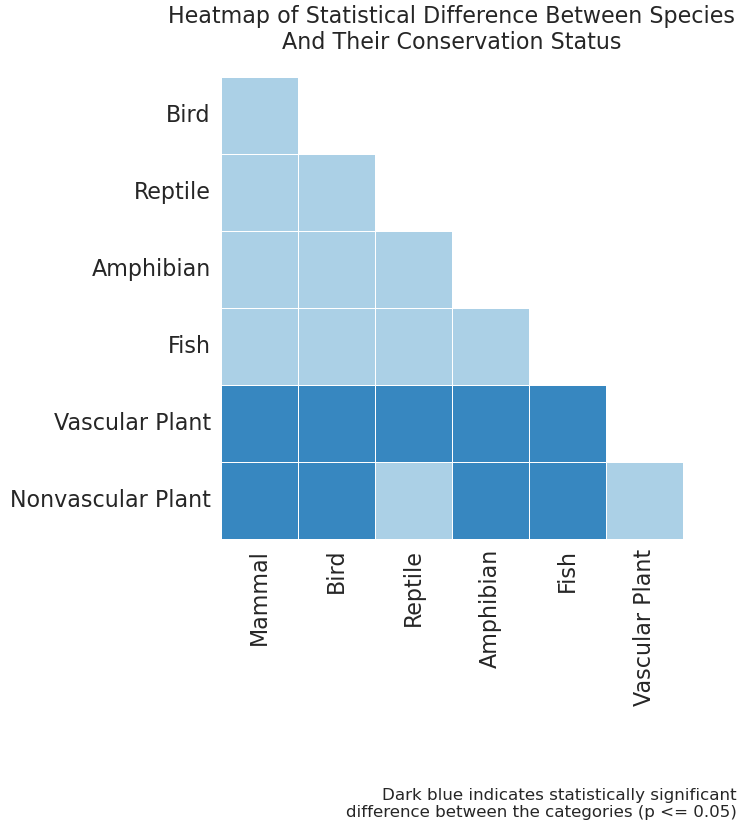

In [99]:
## Heatmap
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(12,6))

    my_colors = sns.color_palette("Blues_r", 2)
    my_cmap = ListedColormap(my_colors)
    bounds = np.linspace(0,0.0025,2)
    my_norm = BoundaryNorm(bounds, ncolors=len(my_colors))

    plt.title("Heatmap of Statistical Difference Between Species\nAnd Their Conservation Status", 
              fontsize = 16, pad=20)

    sns.heatmap(contingency,
                cmap=my_cmap,
                norm=my_norm,
                cbar=False,
                linewidths=.5,
                square=True,
                mask=mask)
    
    plt.xticks(rotation = 90)
    
    txt=f"Dark blue indicates statistically significant\ndifference between the categories (p <= 0.05)"
    plt.figtext(0.75, -0.35, txt, wrap=True, horizontalalignment='right', fontsize=12) 

plt.show()

Analysis:
- Vascular and nonvascular plants are statistically different to all other species (except reptile vs nonvascular plant). There is no statistical difference between the two plant types.

What about individual category vesrsus all species combined (whole population)?
<br><br>
Here are the hypotheses:

- Null Hypothesis: There are no significant differences between the this category and the population.
- Alternative: There are significant differences between the category and the population.
<br><br>
Also, if the null hypothesis is rejected, and number of endangered exceeds the expected number of endangered for the population, then the species is more likely to be endangered than the population. If it's less, than it is less likely to be endangered.

We will be conducting 7 tests, so the adjusted p-value is 0.007

In [100]:
total_count = species.shape[0]
lc_total_count = species.common_names[species.conservation_status == "Least-concern"].count()
end_total_count = total_count - lc_total_count

In [101]:
pvalue = 0.007
contingency = {}

for i in range(len(count_df)):
    x = 0
    lc1 = count_df.lc.iloc[i]
    end1 = count_df.endangered.iloc[i]
    cat1 = count_df.index[i]
    
    _, pval,_,exp= chi2_contingency([[lc1, end1], [lc_total_count, end_total_count]])
            
    if pval <= pvalue:
        print(f"{cat1} vs Population p-value = ", f"{pval:.3}")
        print(f"{cat1} are statistically different than the population.\n")
        
        if end1 >= exp[0][1]:
            print(f"{cat1} are MORE likely to be endangered than the population")
            x = 1
        else:
            print(f"{cat1} are LESS likely to be endangered than the population")
            x = -2
                  
    contingency[cat1] = {"x":x}
    print("\n")

Mammal vs Population p-value =  4.95e-21
Mammal are statistically different than the population.

Mammal are MORE likely to be endangered than the population


Bird vs Population p-value =  7.72e-37
Bird are statistically different than the population.

Bird are MORE likely to be endangered than the population






Fish vs Population p-value =  0.00153
Fish are statistically different than the population.

Fish are MORE likely to be endangered than the population


Vascular Plant vs Population p-value =  2.9e-12
Vascular Plant are statistically different than the population.

Vascular Plant are LESS likely to be endangered than the population






In [102]:
contingency = pd.DataFrame(contingency).T

In [103]:
contingency

,x
Mammal,1
Bird,1
Reptile,0
Amphibian,0
Fish,1
Vascular Plant,-2
Nonvascular Plant,0


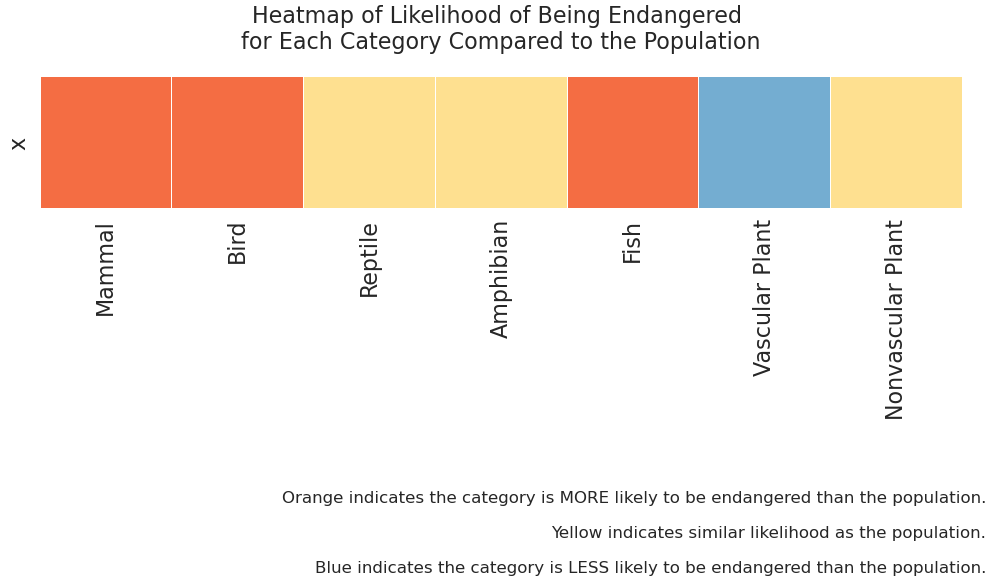

In [104]:
## Heatmap
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(10,6))

    my_colors = sns.color_palette("RdYlBu_r", 4)
    my_cmap = ListedColormap(my_colors)
    bounds = np.linspace(-2,2,5)
    my_norm = BoundaryNorm(bounds, ncolors=len(my_colors))

    plt.title("Heatmap of Likelihood of Being Endangered \nfor Each Category Compared to the Population", 
              fontsize = 16, pad=20)

    sns.heatmap(contingency.T,
                cmap=my_cmap,
                norm=my_norm,
                linewidths=.5,
                cbar=False,
                square=True)
    
    plt.xticks(rotation = 90)
    
    txt=f"""Orange indicates the category is MORE likely to be endangered than the population.\n
Yellow indicates similar likelihood as the population.\n
Blue indicates the category is LESS likely to be endangered than the population."""
    plt.figtext(1, -0.2, txt, wrap=True, horizontalalignment='right', fontsize=12) 

    plt.tight_layout()

plt.show()

Analysis:
- Mammals, birds, and fishes are more likely to be endangered than the rest of the population.
- Vascular plants are less likely to be endangered than the rest of the population.

## 4. Conclusion and Recommendations

In summary:
1. Mammals, birds, and fishes are more likely to be endangered than the rest of the population. Consequently, the majority of species of concern, endangered or threatened species are birds, mammals and fishes, accounting for around 60% of the total. 
2. There is a statistically significant difference between plants (both nonvascular and vascular) and the rest of the species types (except reptile vs nonvascular plants). There is no statistical difference between the two plant types.
2. Whooping Crane (bird type) is the rarest species that was spotted during the observation period, which is around 5 times less likely to be spotted than other endangered birds.
3. Sedge (grass-like plant) is most commonly sighted in all four parks. Excluding plant types, the most frequently sighted species for each park are:
  - Great Smoky Mountains National Park: Unita Chipmunk (Mammal)
  - Yosemite National Park: American Beaver (Mammal)
  - Yellowstone National Park: Eurasian Collared-Dove (Bird)
  - Bryce National Park: Rock Dove (Bird)


Recommendations are:
1. Allocate more resources towards protecting mammanls, birds, and fishes.
2. Notify to park visitors which species are most rarely sighted at each park, and make them aware that visitors should be careful when the species are sighted.
3. Gather more data on each endangered species such as habitat so further analysis can be made on why they are endangered and how we can best protect them.